In [1]:
import os
import pydicom
import numpy as np
from glob import glob
from tqdm import tqdm

# -----------------------------
# 1. Locate all DICOM files
# -----------------------------
TEST_DIR  = "/home/fgj4kw/Downloads/stage_2_test_images"
TRAIN_DIR = "/home/fgj4kw/Downloads/stage_2_train_images"

s2_test_images  = glob(os.path.join(TEST_DIR , "**", "*.dcm"), recursive=True)
s2_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.dcm"), recursive=True)

# -----------------------------
# 2. Down‑sample for quick EDA
# -----------------------------
TEST_SAMPLE_SIZE  = 1_000
TRAIN_SAMPLE_SIZE = 1_000

test_sample  = s2_test_images[:TEST_SAMPLE_SIZE]
train_sample = s2_train_images[:TRAIN_SAMPLE_SIZE]

# -----------------------------
# 3. Containers for stats
# -----------------------------
image_shapes = []
pixel_means  = []
pixel_stds   = []
modalities   = []
patient_ids  = []

def collect_stats(paths, desc):
    print(f"\n🔍 Collecting stats from {desc}...")
    for path in tqdm(paths, desc=desc):
        try:
            ds  = pydicom.dcmread(path, stop_before_pixels=False)
            img = ds.pixel_array

            image_shapes.append(img.shape)
            pixel_means .append(np.mean(img))
            pixel_stds  .append(np.std(img))

            modalities .append(getattr(ds, "Modality" , "Unknown"))
            patient_ids.append(getattr(ds, "PatientID", "Unknown"))
        except Exception as e:
            print(f"⚠️  Skipping {path}: {e}")

# -----------------------------
# 4. Run the collection
# -----------------------------
collect_stats(test_sample , "Test  sample")
collect_stats(train_sample, "Train sample")

# -----------------------------
# 5. Quick summary
# -----------------------------
all_files = s2_test_images + s2_train_images
print("\n📊 — Dataset summary —")
print(f"🖼️  Total DICOM files available : {len(all_files):,}")
print(f"📦 Sample used for EDA         : {len(test_sample):,} test | {len(train_sample):,} train")
print(f"📐 Unique image shapes found   : {set(image_shapes)}")
print(f"🩻 Unique modalities found     : {set(modalities)}")
print(f"👤 Unique patients in sample   : {len(set(patient_ids)):,}")

# -----------------------------
# 6. Tiny data dictionary
# -----------------------------
data_dict = {
    "pixel_array": "2‑D NumPy array of raw pixel values",
    "Modality"   : "Imaging modality (e.g., CT, MR, CR)",
    "PatientID"  : "De‑identified unique patient identifier",
    "pixel_mean" : "Mean pixel intensity of the image",
    "pixel_std"  : "Standard deviation of pixel intensity",
}

print("\n📚 — Data dictionary —")
for key, val in data_dict.items():
    print(f" - {key}: {val}")


🔍 Collecting stats from Test  sample...


Test  sample: 100%|██████████| 1000/1000 [01:16<00:00, 13.14it/s]



🔍 Collecting stats from Train sample...


Train sample: 100%|██████████| 1000/1000 [01:07<00:00, 14.78it/s]


📊 — Dataset summary —
🖼️  Total DICOM files available : 29,684
📦 Sample used for EDA         : 1,000 test | 1,000 train
📐 Unique image shapes found   : {(1024, 1024)}
🩻 Unique modalities found     : {'CR'}
👤 Unique patients in sample   : 2,000

📚 — Data dictionary —
 - pixel_array: 2‑D NumPy array of raw pixel values
 - Modality: Imaging modality (e.g., CT, MR, CR)
 - PatientID: De‑identified unique patient identifier
 - pixel_mean: Mean pixel intensity of the image
 - pixel_std: Standard deviation of pixel intensity


📊 RSNA Pneumonia Detailed Class Summary:
 - Lung Opacity                       : 6,012
 - No Lung Opacity / Not Normal       : 11,821
 - Normal                             : 8,851


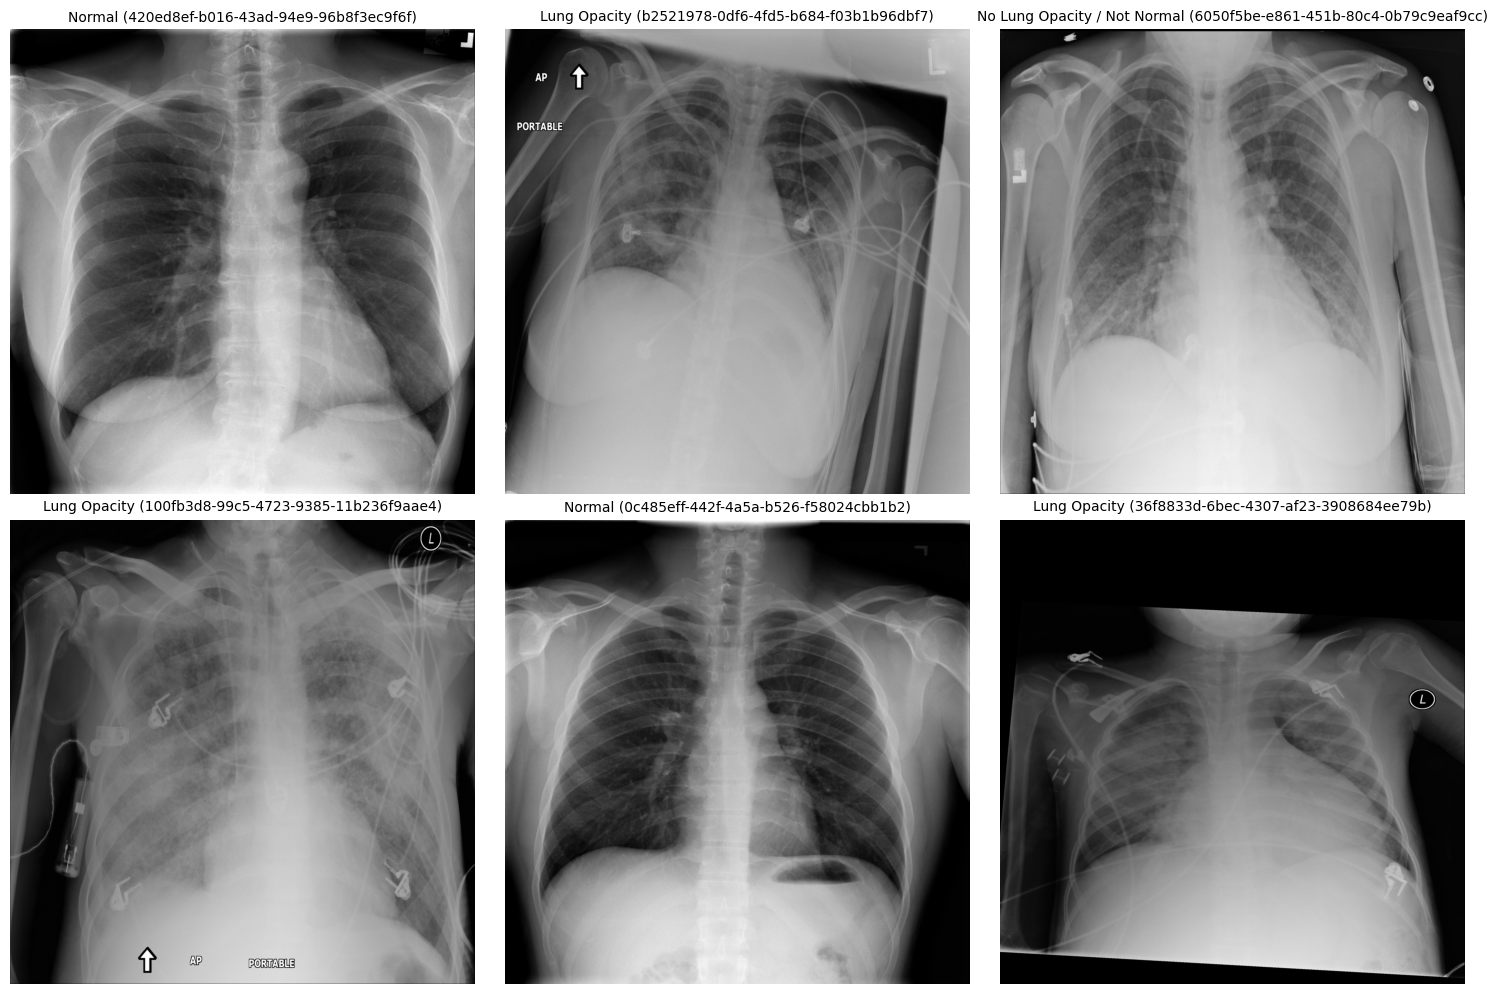

In [1]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import os
import random

# === Step 1: Load labels ===
labels_df = pd.read_csv('/home/fgj4kw/Downloads/stage_2_train_labels.csv')
class_info_df = pd.read_csv('/home/fgj4kw/Downloads/stage_2_detailed_class_info.csv')  # Adjusted to uploaded path

# Merge the detailed class info with labels
merged_df = pd.merge(labels_df, class_info_df, on='patientId', how='left')

# Create a dict: patientId → detailed class label
class_dict = merged_df.groupby('patientId')['class'].first().to_dict()

# === Step 2: Print summary statistics ===
label_counts = merged_df.groupby('class')['patientId'].nunique()

print("📊 RSNA Pneumonia Detailed Class Summary:")
for label, count in label_counts.items():
    print(f" - {label:<35}: {count:,}")

# === Step 3: Sample 6 patientIds ===
sample_ids = random.sample(list(class_dict.keys()), 6)

# === Step 4: Plot the images with detailed labels ===
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, pid in zip(axes.flatten(), sample_ids):
    dicom_path = os.path.join('/home/fgj4kw/Downloads/stage_2_train_images', f'{pid}.dcm')
    ds = pydicom.dcmread(dicom_path)
    img = ds.pixel_array
    label = class_dict.get(pid, 'Unknown')
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{label} ({pid})", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()



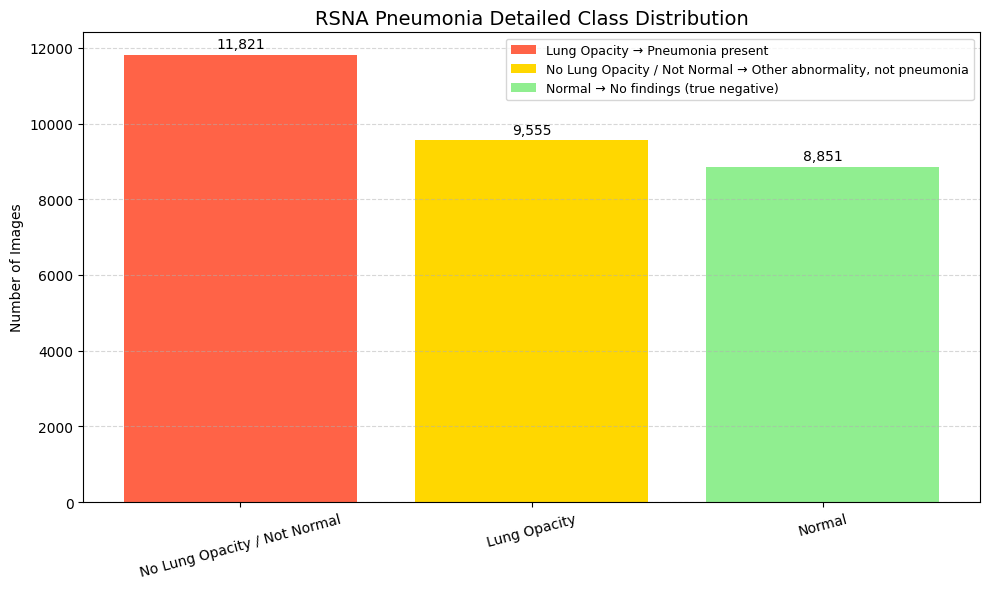

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load data ===
class_info_df = pd.read_csv('/home/fgj4kw/Downloads/stage_2_detailed_class_info.csv')

# === Count classes ===
class_counts = class_info_df['class'].value_counts()
labels = class_counts.index.tolist()
values = class_counts.values

# === Bar chart ===
colors = ['tomato', 'gold', 'lightgreen']
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height:,}',
             ha='center', va='bottom', fontsize=10)

# Titles and labels
plt.title("RSNA Pneumonia Detailed Class Distribution", fontsize=14)
plt.ylabel("Number of Images")
plt.xticks(rotation=15)

# === Correct legend setup ===
custom_labels = [
    "Lung Opacity → Pneumonia present",
    "No Lung Opacity / Not Normal → Other abnormality, not pneumonia",
    "Normal → No findings (true negative)"
]
plt.legend(handles=bars, labels=custom_labels, loc='upper right', fontsize=9, frameon=True)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
